# Processing data from Beigang1982.PS.26.183

One-Photon Laser Spectroscopy of Rydberg Series from Metastable Levels in Calcium and Strontium
R Beigang, K Lücke, D Schmidt, A Timmermann and P J West
Phys. Scr. 26 183 (1982)
https://doi.org/10.1088/0031-8949/26/3/007

In [1]:
import os
import glob

import pandas as pd
import numpy as np
from uncertainties import ufloat, unumpy

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')

## Constants
Constants to be set for each particular data set.

In [2]:
# Constants that should not need changing
C = 299792458 # Speed of light in [m/s]

# CODATA 2014 constants
RY_inf = ufloat(10973731.568508, 0.000065)/100 # Rydberg constant [/cm]
AMU = ufloat(1.660539040, 0.000000020)*1E-27 # Atomic mass unit [kg]
M_E = ufloat(9.10938356, 0.00000011)*1E-31 # Electron mass [kg]

M_88 = ufloat(87905612.256, 0.006)*1E-6*AMU
M_87 = ufloat(86908877.496, 0.005)*1E-6*AMU
M_86 = ufloat(85909260.726, 0.006)*1E-6*AMU
M_84 = ufloat(83913419.1, 1.3)*1E-6*AMU

out = pd.DataFrame(columns=['Series','n', 'Term', 'Label', 'E_exp', 'E_exp_unc', 'Isotope', 'Reference'])

In [3]:
# Constants which should change depending on the data set being analyzed
REFERENCE = 'Beigang1982.PS.26.183'
PATH_TO_RAW_DATA = os.path.join('source','Beigang1982.PS.26.183*.csv')
OUTPUT_FILE_NAME = REFERENCE + '-analyzed.csv'

ISOTOPE = 88

I_S = ufloat(1377012721, 10)/(C*100/1E6) # Given ionization limit for 88Sr in paper.

#RY_Sr = 109736.631 # Rydberg constant in [/cm]
RY_Sr = RY_inf*(M_88/(M_E + M_88))

## Read in all the files to a single DataFrame

In [4]:
# Goes through all listed .csv files and returns data in a single DataFrame

source_list = glob.glob(PATH_TO_RAW_DATA)

def gather_data(file_list):
    
    # Read in .csv files in to single DataFrame
    out = pd.DataFrame()
    for file_name in file_list:
        df = pd.read_csv(file_name)
        
        out = pd.concat([out, df], join='outer', ignore_index=True, sort=False)
    
    return out

data = gather_data(source_list)

## Process data
May need to tweak depending on the data set being analyzed.

### Adding in uncertainty

In [5]:
# The paper gives +/-0.15 /cm uncertainty for all their data.
data['E_exp_unc'] = 0.15

### Doing any additional filtering (e.g., excluding some ranges, etc.)

In [6]:
# Only keep data that's newly presented (some data tables include previously measured data)
data_working = data[data['New'] & ~pd.isna(data['New'])]

### Put data in to a standardized table

In [7]:
# Only keep data that's newly presented (some data tables include previously measured data)
out['Term'] = data_working['Term']
out['n'] = data_working['n']
out['E_exp'] = data_working['E_exp']
out['E_exp_unc'] = data_working['E_exp_unc']

# Set the isotope
out['Isotope'] = ISOTOPE
out['Reference'] = REFERENCE

# Specify the series based on the term
#for idx, row in out.iterrows():
#    if row['Term'] == '3S1':
#        out.at[idx, 'Series'] = '5sns'
#    elif row['Term'] == '1D2' or row['Term'] == '3D1' or row['Term'] == '3D2' or row['Term'] == '3D3':
#        out.at[idx, 'Series'] = '5snd'
#    else:
#        print('Error with assigning series')
out['Series'] = data_working['Series']

# Label the states
for idx, row in out.iterrows():
    out.at[idx, 'Label'] = row['Series'].replace('n', str(row['n']))


### Calculate quantum defect

In [8]:
n = out['n']
E_exp = unumpy.uarray(out['E_exp'], out['E_exp_unc'])
delta_expt = n - unumpy.sqrt(RY_Sr/(I_S-E_exp))

out['delta_exp'] = unumpy.nominal_values(delta_expt)
out['delta_exp_unc'] = unumpy.std_devs(delta_expt)

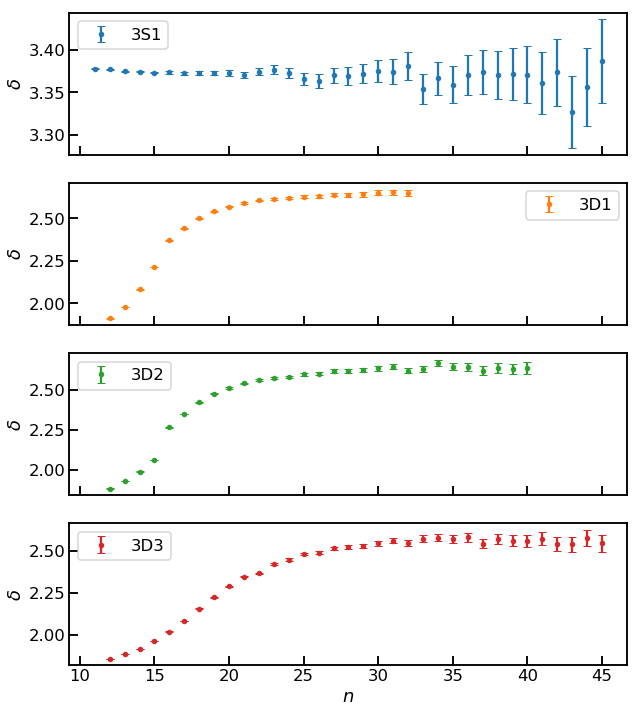

In [9]:
plt_kwargs = {'capsize':4,
              'fmt':'.'}

nrows = len(out['Term'].unique())

if nrows > 1:
    [fig, axs] = plt.subplots(nrows=nrows, ncols=1, figsize=(10,3*nrows), sharex=True, sharey=False)

    for i, T in enumerate(out['Term'].unique()):
        x = out[out['Term'] == T]['n']
        y = out[out['Term'] == T]['delta_exp']
        yerr = out[out['Term'] == T]['delta_exp_unc']
        axs[i].errorbar(x, y, yerr=yerr, label=T, **plt_kwargs, color=sns.color_palette()[i])
        axs[i].legend()
        axs[i].tick_params(axis='both', direction='in')
        axs[i].set_ylabel(r'$\delta$')

    plt.xlabel(r'$n$')
    plt.show()

else:
    plt.figure(figsize=(10,3))
    
    T = out['Term'].unique()[0]
    
    x = out['n']
    y = out['delta_exp']
    yerr = out['delta_exp_unc']
    plt.errorbar(x, y, yerr=yerr, label=T, **plt_kwargs, color=sns.color_palette()[0])
    plt.legend()
    plt.gca().tick_params(axis='both', direction='in')

    plt.xlabel(r'$n$')
    plt.ylabel(r'$\delta$')
    plt.show()

### Write out processed data as .csv

In [10]:
out.to_csv(OUTPUT_FILE_NAME, index=False)